# Edge AI Anomaly Detection

## Overview

This document contains the code for our EclipseCON 2022 Talk: "_How to Train Your Dragon and Its Friends: AI on the Edge with Eclipse Kura&trade;_"

In this notebook we'll cover:
- **Data collection**: how to retrieve training data from the field leveraging Eclipse Kura&trade; and Eclipse Kapua&trade;
- **Data exploration**: how to explore our training data and manipulate them to make them suitable for training
- **Model training**: how we can create a simple Autoencoder in Keras and how to train it
- **Model performance evaluation**: how can we ensure the model was trained correctly
- **Model conversion**: how we can convert the model to make it suitable for running on Eclipse Kura&trade; and Nvidia Triton&trade;
- **Model deployment**: how can we deploy our model on our final device and use it for real-time anomaly detection

---

## Data collection

[WIP]

---

## Data Exploration

We can now work on our `.csv` file downloaded from Kapua. For demonstration purposes a copy is provided within this repository.

In [4]:
!ls *.csv

train-data-raw.csv


Let's start taking a look at the content of this dataset, we'll use [pandas](https://pandas.pydata.org/) (Python Data Analysis library) for this.

As you might notice we're already taking away some features from the dataset (through the `usecols` parameter of the `read_csv` function). This is because there's some information in the dataset we don't care about (`ID` and the timestamps, for example, are not meaningful for our application).

In [3]:
import pandas as pd

features = ['ACC_Y', 'ACC_X', 'ACC_Z',
            'PRESSURE', 'TEMP_PRESS', 'TEMP_HUM',
            'HUMIDITY', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']

train_data = pd.read_csv("./train-data-raw.csv", usecols=features)

train_data.head()

,ACC_Y,ACC_X,ACC_Z,PRESSURE,TEMP_PRESS,TEMP_HUM,HUMIDITY,GYRO_X,GYRO_Y,GYRO_Z
0,0.004364,0.080122,0.984048,992.322998,38.724998,40.330822,19.487146,0.053243,0.028920,0.036950
1,0.005091,0.080122,0.992090,992.288330,38.772915,40.385788,19.465750,-0.051105,-0.028920,-0.037256
2,0.005334,0.080122,0.986729,992.275635,38.795834,40.349144,19.572731,-0.025253,0.025560,0.038478
3,0.006061,0.080122,0.990384,992.279053,38.797916,40.330822,19.358767,0.100695,-0.023422,-0.037867
4,0.004849,0.080607,0.988922,992.333008,38.845833,40.385788,19.390862,-0.100389,0.021895,0.038172


In [4]:
train_data.describe()

,ACC_Y,ACC_X,ACC_Z,PRESSURE,TEMP_PRESS,TEMP_HUM,HUMIDITY,GYRO_X,GYRO_Y,GYRO_Z
count,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000
mean,0.003544,0.085134,0.989769,992.845161,43.187341,44.713421,17.902183,-0.002612,-0.000896,-0.000403
std,0.011132,0.003027,0.013210,1.729313,2.124413,2.087316,1.851455,0.242927,0.032771,0.013528
min,-0.132551,-0.049693,0.759847,976.001709,38.724998,40.220890,13.003981,-1.937896,-0.265019,-0.250647
25%,0.002182,0.083763,0.987460,991.420471,42.417189,43.811989,16.423868,-0.001888,-0.001277,-0.000944
50%,0.003637,0.084977,0.990140,992.682983,43.554165,45.167809,18.378090,0.000019,-0.000103,-0.000043
75%,0.005334,0.086434,0.991846,993.691284,44.762501,46.193836,19.044949,0.002204,0.001007,0.000779
max,0.093099,0.150289,1.177543,1007.996338,46.093750,48.355824,23.506138,1.923712,0.219204,0.671759


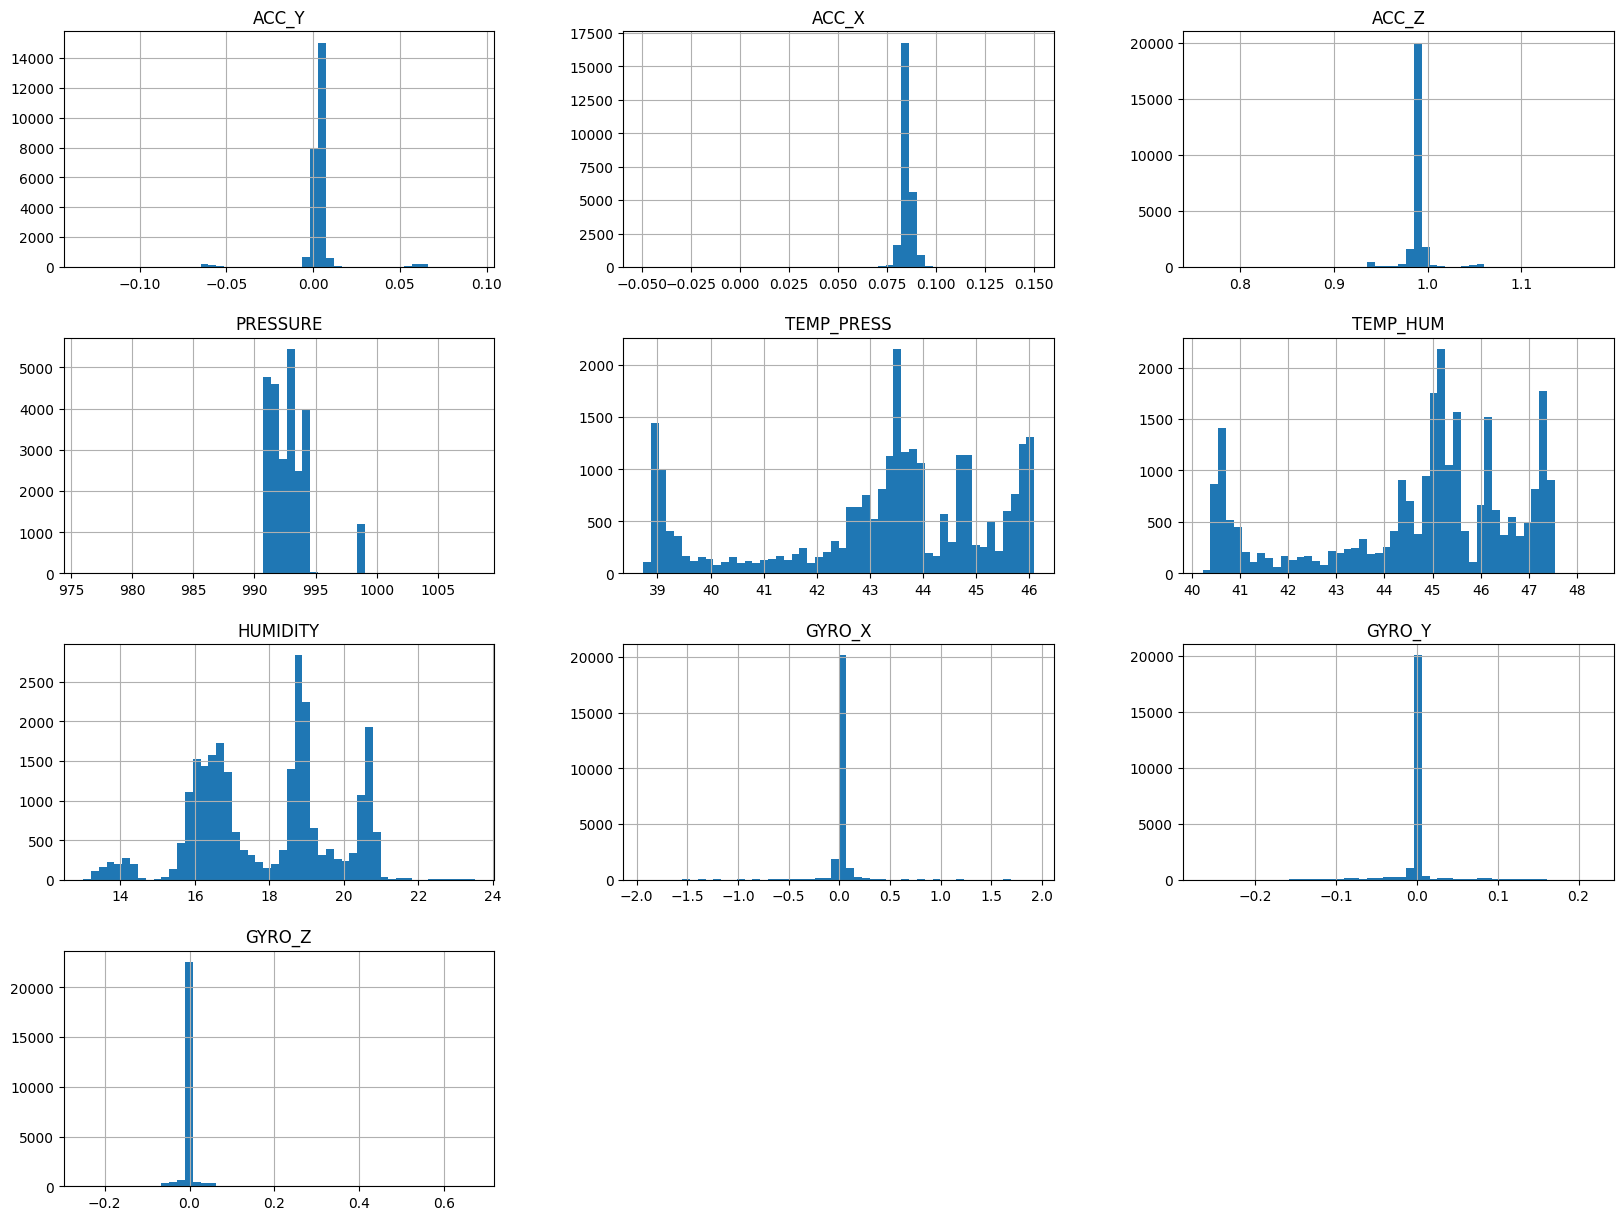

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=50, figsize=(20,15))
plt.show()

### Feature scaling

AI models don't perform well when the input numerical attributes have very different scales. As you can see `ACC_X`, `ACC_Y` and `ACC_Z` range from 0 to 1, while the `PRESSURE` have far higher values.

There are two common ways to address this: _normalization_ and _standardization_.

_Normalization_ (a.k.a. Min-max scaling) shifts and rescales values so that they end up ranging from 0 to 1. This can be done by subtracting the min value and dividing by the max minus the min.

x' = $\frac{x - min(x)}{max(x) - min(x)}$

_Standardization_ makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

x' = $\frac{x - avg(x)}{\sigma}$

Fortunately for us [scikit-learn](https://scikit-learn.org/stable/) library provides a function for both of them. In this case we'll use _normalization_ because it works well for this application.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data.to_numpy())

In [8]:
pd.DataFrame(scaled_train_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000
mean,0.603124,0.674196,0.550454,0.526446,0.605576,0.552252,0.466400,0.501160,0.545457,0.271295
std,0.049333,0.015135,0.031627,0.054050,0.288300,0.256587,0.176293,0.062908,0.067678,0.014665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.597087,0.667343,0.544924,0.481917,0.501060,0.441442,0.325637,0.501348,0.544670,0.270709
50%,0.603534,0.673413,0.551342,0.521377,0.655357,0.608108,0.511715,0.501841,0.547096,0.271685
75%,0.611055,0.680698,0.555426,0.552892,0.819339,0.734234,0.575212,0.502407,0.549386,0.272577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---

## Model creation

We can now leverage the [Keras](https://keras.io/) API of [Tensorflow](https://www.tensorflow.org/) for creating our Autoencoder.

As we already explained in the documentation, the autoencoder is a  type of artificial neural network used to learn efficient codings of unlabeled data. We'll use that to reconstruct the input at the output. Being trained on the "normal" data of the system, it won't be able to reconstruct correctly "anomalous" data and thus will work as an anomaly detector.

In this example we'll use a basic fully-connected autoencoder.

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_model(input_dim):
    # Latent space dimension
    latent_dim = 4

    # The encoder will consist of a number of dense layers that decrease in size
    # as we taper down towards the bottleneck of the network, the latent space
    input_data = Input(shape=(input_dim,), name='INPUT0')

    # hidden layers
    encoder = Dense(24, activation='tanh', name='encoder_1')(input_data)
    encoder = Dropout(.15)(encoder)
    encoder = Dense(16, activation='tanh', name='encoder_2')(encoder)
    encoder = Dropout(.15)(encoder)

    # bottleneck layer
    latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

    # The decoder network is a mirror image of the encoder network
    decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
    decoder = Dropout(.15)(decoder)
    decoder = Dense(24, activation='tanh', name='decoder_2')(decoder)
    decoder = Dropout(.15)(decoder)

    # The output is the same dimension as the input data we are reconstructing
    reconstructed_data = Dense(input_dim, activation='linear', name='OUTPUT0')(decoder)

    autoencoder_model = Model(input_data, reconstructed_data)

    return autoencoder_model

2022-09-22 12:20:40.648175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
autoencoder_model = create_model(scaled_train_data.shape[1])

2022-09-22 12:20:57.995514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
